In [1]:
import numpy as np
import scipy.linalg as sla
import scipy.sparse as sps
import scipy.sparse.linalg as spla

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Лабораторная работа 2. SVD

**Внимание! Заданий много, но вам не обязательно делать все, даже чтобы получить синюю клетку**

Так что можете не делать их подряд, а сначала посмотреть все и выбрать те, которые вам больше нравятся.

## 1. Сжатие информации с помощью SVD (3 балла)

Загрузите выложенную на странице курса фотографию кураторов ШАД.

Поскольку фотография чёрно-белая, её можно проинтерпетировать как матрицу, элементы которой - это насыщенность серого цвета каждого из пикселей. Постройте сингулярное разложение этой матрицы (не нужно центрировать данные!). 

Визуализуйте первую главную компоненту. Ожидали ли вы увидеть именно это? Почему?

Визуализуйте компонеты с первой по двадцатую, с первой по пятидесятую, с двадцатой по сотую, с двадцатой по последнюю. Сделайте выводы.

Как вам кажется, сколько первых компонент нужно взять для достаточно хорошего восстановления исходного изображения? Во сколько раз меньше памяти потребуется для их хранения?

**Важное замечание.** Главные компоненты - это не скрытые признаки, а матрицы вида $u^{(i)}\sigma_i(v^{(i)})^T$, где $u^{(i)}, v^{(i)}$ --- столбцы матриц $U$ и $V$ соответственно. В частности, сумма первых нескольких главных компонент --- это наилучшее приближение исходной матрицы матрицей данного ранга.

### Решение

Загрузим изображение

In [2]:
from matplotlib.pyplot import imread
from skimage.color import rgb2gray

img = np.int32(rgb2gray(imread(r'./curators.jpg')) * 255) # это матрица из интенсивностей серого цвета; её уже можно подвергать SVD

Нарисуем картинку!

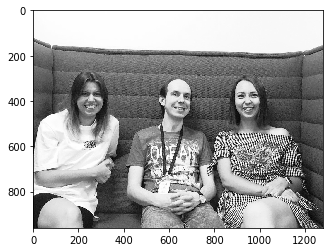

In [3]:
imgplot = plt.imshow(img, cmap='Greys_r')

In [4]:
def GetVisualizationComponents(matrix, begin, end = None):
    U, S, Vh = sla.svd(matrix)
    approx_matrix = np.zeros(matrix.shape)
    if end is None:
        end = len(S)
    for i in range(begin, end):
        i_component = U[:, i:i+1].dot(S[i] * Vh[i:i+1, :])
        approx_matrix += i_component
    plt.imshow(approx_matrix, cmap='Greys_r')
    plt.title("Компоненты с {} по {}".format(begin + 1, end))
    plt.show()

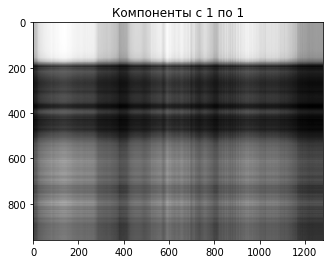

In [5]:
GetVisualizationComponents(img, 0, 1)

**Вывод:** Результат ожидаем. Понятно, что с помощью одной компоненты мы не сможем достаточно хорошо приблизить данное изображение. Кроме того, видно, что черные линии от дивана перекрывают головы наших кураторов, а их одежда выделяется на темном фоне только благодаря чуть более светлым оттенкам. В целом, приближение является достаточно грубым: почти невозможно понять, что на нём изображено.

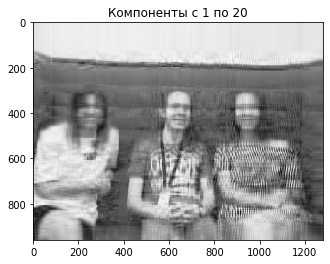

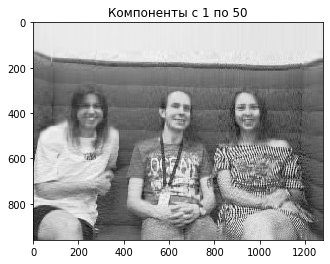

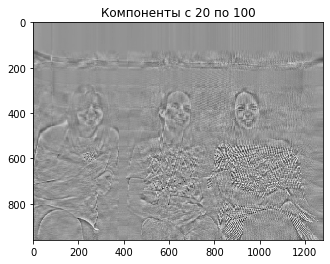

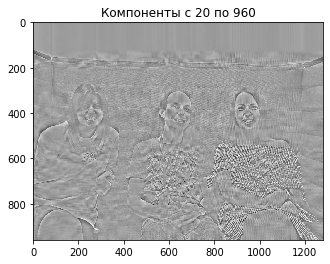

In [6]:
GetVisualizationComponents(img, 0, 20)
GetVisualizationComponents(img, 0, 50)
GetVisualizationComponents(img, 19, 100)
GetVisualizationComponents(img, 19)

**Вывод:** Можно сделать однозначный вывод про главные компоненты на примерах. Они сохраняют основные черты изображения (цвет и некоторые основные контуры). На первых двух изображениях мы видим почти распознаваемые изображения, которые напоминают те изображения, которые размыли. На последних двух изображениях компоненты скорее всего описывают только контуры.

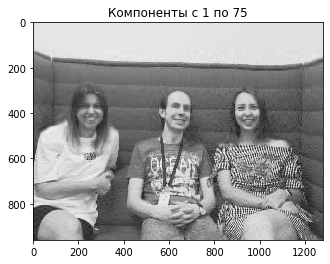

In [7]:
GetVisualizationComponents(img, 0, 75)

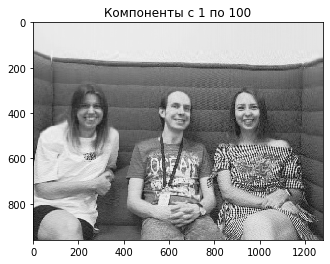

In [8]:
GetVisualizationComponents(img, 0, 100)

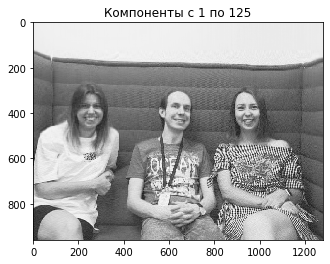

In [9]:
GetVisualizationComponents(img, 0, 125)

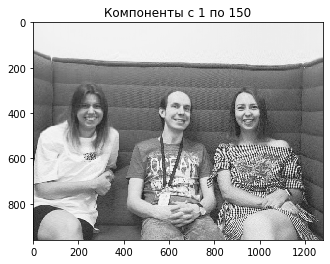

In [10]:
GetVisualizationComponents(img, 0, 150)

In [11]:
img.shape

(960, 1280)

In [12]:
(img.shape[0] * img.shape[1]) / ((img.shape[0] + img.shape[1] + 1) * 125)

4.38661311914324

**Вывод:** Немного поэкспериментировав, думаю, что 100-125 первых компонент было бы вполне достаточно для хорошего восстановления исходного изображения, т.к. не вижу на глаз сильных различий между использованием 125 и 150 первых компонент, однако при использовании 125 лица кураторов лучше видно (они посветлее на фоне дивана :D ), чем при использовании 100 компонент.

Допустим, что исходное изображение имеет размер m*n, тогда для его хранения в SVD-разложении потребуется m*k памяти для хранения строк в матрице U, n*k - для матрицы V и k для хранения элементов на диагонали матрицы $\Sigma$. Тогда получаем, что в $\frac{mn}{(m+n+1)k}$ раз нужно иметь больше памяти для хранения исходного изображения. Если мы возьмем 125 первых компонент, то в $\frac{960*1280}{(960 + 1280 + 1) * 125} \approx 4.4$ раза выигрыш в памяти при использовании SVD.

## 2. SVD и свёртки (до 5 баллов)

В компьютерном зрении важную роль играет операция свёртки. Вообще говоря, сворачивать приходится не только матрицы, но и более сложные тензоры, однако в этом задании мы для простоты будем работать только с матрицами.

В этом задании мы будем считать, что индексы элементов в матрицах нумеруются с нуля.

Пусть $B$ --- матрица. *Свёртка* матрицы $A$ с ядром (или, как ещё говорят, с фильтром) $B$ - это матрица

$$(A * B)_{ij} = \sum_{p, q}a_{pq}b_{i - p, j - q}$$

Эту загадочную операцию можно проинтерпретировать следующим образом: для каждого элемента матрицы $A$ мы умножаем его "окрестность" (размеры этой окрестности зависят от размеров фильтра) поэлементно на соответствующие коэффициенты из ядра и всё это складываем:

<img src="http://colah.github.io/posts/2014-07-Understanding-Convolutions/img/RiverTrain-ImageConvDiagram.png">

Таким образом, каждый элемент $A$ мы как-то обновляем с учётом его соседей. Скажем, свёртка с ядром

$$B = \frac19\begin{pmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1
\end{pmatrix}$$

будет размывать изображение.

У вас может возникнуть вопрос: а что происходит на краях? Пусть $A$ - матрица $m\times n$, а $B$ - матрица $k\times l$. Есть разные варианты, например, такие:

- можно считать, что "за пределами" $A$ и $B$ тоже есть элементы, но просто они равны нулю; тогда результат свёртки будет иметь размер $(m + k - 1)\times(n + l - 1)$;
- можно точно так же считать, что элементы, лежащие "за пределами" $A$ и $B$ равны нулю, но законными считать только те компоненты свёртки, для которых "центр" фильтра попадает в матрицу $A$, тогда результат свёртки будет иметь такой же размер, как и $A$;
- можно считать законными только те компоненты свёртки, для которых фильтр целиком помещается "внутри" $A$; в этом случае результат свёртки будет меньшего размера, чем исходная матрица, а именно $(m - k + 1)\times(n - l + 1)$.

Дальше мы будем по умолчанию считать, что границы обрабатываются первым из указанных способов.

Свёртка называется *сепарабельной*, если она представляется в виде композиции свёрток

$$A * B = (A * U) * V,$$

где $U$ и $V$ - матрицы $(2t+1)\times1$ и $1\times(2s+1)$ (или $1\times(2s+1)$ и $(2t+1)\times1$).

**Собственно задание:**

0) Сверните фотографию Сони с фильтром

$$B = \begin{pmatrix}
-1 & -1 & -1\\
-1 & 8 & -1\\
-1 & -1 & -1
\end{pmatrix}$$

Границы можете обработать любым приятным вам способом. Как вам кажется, каков физический смысл этой операции?

1) Проверьте, что операция свёртки (в которой границы обрабатываются первым из указанных способов!) ассоциативна, то есть $(A * B) * C = A * (B * C)$;

2) Убедитесь, что сепарабельную свёртку можно посчитать быстрее, чем не сепарабельную;

3) Допустим, что вам нужно реализовать операцию свёртки с фильтром $B$, однако приоритетом для вас является скорее скорость, а не абсолютная точность, и поэтому вы готовы ценой не очень большой ошибки заменить исходную свёртку на какую-нибудь сепарабельную. Какую именно векторы $U$ и $V$ вы бы использовали в этом случае? Почему? Попробуйте оценить ошибку.

4) Докажите, что любую свёртку можно выполнить, используя лишь операции свёртки с векторами (векторами-строками и/или векторами-столбцами) и операцию сложения.

0) Свернем фотографию кураторов с данным фильтром 

In [13]:
def GetConvImg(img, conv):
    ans = np.zeros((img.shape[0] - conv.shape[0] + 1, img.shape[1] - conv.shape[1] + 1))
    for i in range(ans.shape[0]):
        for j in range(ans.shape[1]):
            matr = img[i:i + conv.shape[0], j:j + conv.shape[1]]
            ans[i][j] = np.sum(matr * conv)
    return ans

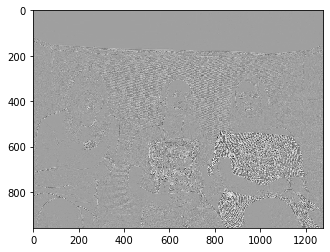

In [14]:
conv = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
conv_img = GetConvImg(img, conv)
plt.imshow(conv_img, cmap='Greys_r')
plt.show()

Во-первых, заметим, что, если в некоторой окрестности пиксели приблизительно одинаковые (например, это видно на лицах кураторов и руках Саши), то применение свёртки к этой области вернет что-то монотонное, а значение пикселей будет близко к 0. Во-вторых, заметим, что в остальных местах применение свёртки даёт что-то рандомное: темный цвет с крапинками белого. Так же стоит заметить, что контуры между монотонным цветом и чем-то рандомным хорошо видны. В целом данный фильтр можно применять для нахождения контуров.

1) $((A*B)*C)_{i, j} = \sum\limits_{p,q} (AB)_{p,q}C_{i-p,j-q} = \sum\limits_{p, q} \sum\limits_{k,l} A_{k,l} B_{p-k, q-l}C_{i-p,j-q} = \sum\limits_{k,l} A_{k,l} \sum\limits_{p, q} B_{p-k, q-l}C_{i-p,j-q} = \sum\limits_{k,l} A_{k,l} (\sum\limits_{p, q} B_{p-k, q-l}C_{i-p,j-q}) = \sum\limits_{k,l} A_{k,l} (\sum\limits_{p + k, q + l} B_{p, q}C_{i-p-k,j-q-l}) = \sum\limits_{k,l} A_{k,l} (BC)_{i-k, j-l} = (A*(B*C))_{i,j}$

2) Пусть имеется матрица $A$ размера $m*n$ и фильтр $B$ размера $k*l$. Тогда не сепарабельную свертку найдем за $(m+k-1)*(n+l-1)*k*l$. Теперь рассмотрим сеперабельную свертку $AB = (AU)V$, где $U$ - столбец $k*1$, $V$ - столбец $1*l$. Её найдем за $(m+k-1)(n+1-1)*k*1 + ((m+k-1)+1-1)*((n+1-1)+l-1)*1*l$ операций. Второе выражение больше первого.

3) Выше мы видели, что SVD-разложение хорошо приблежает фотографии, поэтому почему бы не попробовать разложить свертку $B$. Тогда $B=U \Sigma V^{T}$. В качестве приближения можно взять первую главную компоненту, т.к. она несёт в себе большую часть информации, т.е. $u^{(1)}\sigma_1(v^{(1)})^T$, где $u^{(1)}, v^{(1)}$ - столбцы матриц $U$ и $V$ соответственно.

Оценим норму разности: $||B-\hat{B}||_{2} = ||U \Sigma V^{T} - U \Sigma_{2} V^{T}|| = ||U(\Sigma - \Sigma_{2})V^{T}|| = \sigma_{2}$, т.к. $U$ и $V$ - ортогональные матрицы, а наибольшее значение в $\Sigma - \Sigma_{2}$ равно $\sigma_2$.

4) Понятно, что свертка суммы равна сумме сверток. Для доказательства использования только операций над векторами-строками и векторами-столбцами разложим матрицу свёртки $B$, как сумму произведений матрицы-столбца на матрицу-строку (это можно сделать с помощью SVD-разложения и в силу пункта 3, где было показано что свертку можно разложить на сепарабельную (т.е. на композицию двух сверток)). Тогда получаем, что каждую свертку можно разложить на сумму произведений двух сверток, каждая из которой является вектором-строкой или вектором-столбцом.

## 3. Снижение размерности с помощью SVD (4 балла)

В этом задании вам предстоит работать с подмножеством датасета, повествующего о химическом составе воды в некоторых реках (источник датасета здесь: http://data.europa.eu/euodp/en/data/dataset/data_waterbase-rivers-10). Данные лежат в файле `dataset_final`, который можно скачать на странице курса.

Загрузим же его поскорей:

In [15]:
import pickle
index_list, feature_list, data_matrix = pickle.load(open('dataset_final', 'rb'))

Несколько слово о том, что это за три сущности:
* `index_list` - список id рек, которые были отобраны для задания (если вам захочется узнать, что именно скрывается за этими ужасными id, расшифровки есть в таблице `Waterbase_rivers_v14_Stations.csv`, которую мы для удобства загрузили на вики)
* `feature_list` - список признаков (они имеют вид `год ПРОБЕЛ показатель`)
* `data_matrix` - собственно данные (строки соответствуют рекам из `index_list`, а столбцы - признакам из `feature_list`)

Ваше первое задание - сделать так, чтобы отрисовка всех объектов в координатах первых двух "скрытых" признаков, полученных с помощью SVD, давала хорошую визуализацию датасета. Изначально к этому будут некоторого рода препятствия; мы ожидаем, что вы их устраните.

Сравните результаты с тем, что получилось бы, если воспользоваться [случайными гауссовскими проекциями](http://scikit-learn.org/stable/modules/random_projection.html). Они вызываются следующими заклинаниями:

```
X = # Your matrix
transformer = random_projection.GaussianRandomProjection(n_components='''how many?''')
X_new = transformer.fit_transform(X)
```

Попробуйте понять, какой физический смысл имеют первые три "скрытых" признака, полученных с помощью SVD.

Какие выводы о данных вы можете сделать из построенной визуализации?

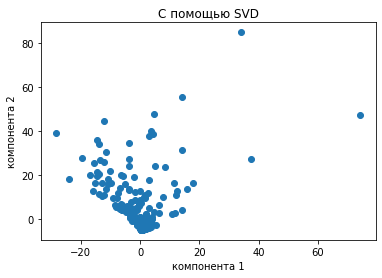

In [16]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
scaled_matrix = scaler.fit_transform(data_matrix)

U, S, Vh = spla.svds(scaled_matrix, k=2, which='LM')
closed_features = U.dot(np.diag(S))

plt.title('С помощью SVD')
plt.xlabel('компонента 1')
plt.ylabel('компонента 2')
plt.scatter(closed_features[:, 0], closed_features[:, 1])

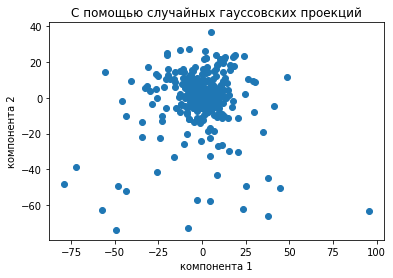

In [17]:
from sklearn import random_projection

X = scaled_matrix
transformer = random_projection.GaussianRandomProjection(n_components=2)
X_new = transformer.fit_transform(X)

plt.title('С помощью случайных гауссовских проекций')
plt.xlabel('компонента 1')
plt.ylabel('компонента 2')
plt.scatter(X_new[:,0], X_new[:, 1])

In [18]:
U, S, Vh = spla.svds(scaled_matrix, k=3, which='LM')
closed_features = U.dot(np.diag(S))

X = scaled_matrix
transformer = random_projection.GaussianRandomProjection(n_components=3)
X_new = transformer.fit_transform(X)

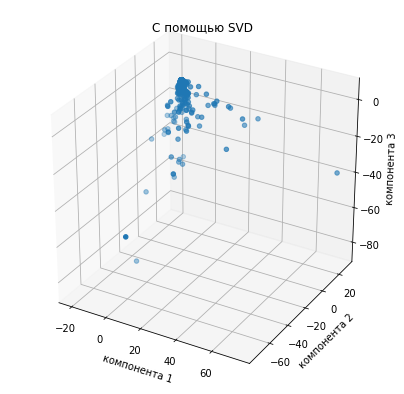

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(closed_features[:, 0], closed_features[:, 1], closed_features[:, 2])

ax.set_xlabel('компонента 1')
ax.set_ylabel('компонента 2')
ax.set_zlabel('компонента 3')

plt.title('С помощью SVD')
plt.show()

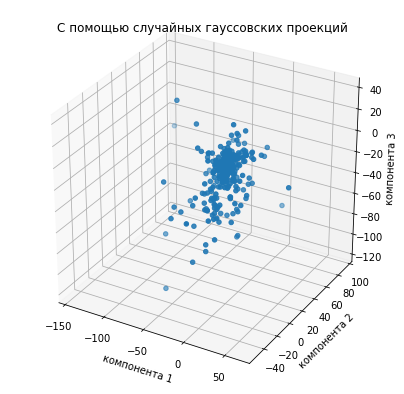

In [20]:
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_new[:, 0], X_new[:, 1], X_new[:, 2])

ax.set_xlabel('компонента 1')
ax.set_ylabel('компонента 2')
ax.set_zlabel('компонента 3')

plt.title('С помощью случайных гауссовских проекций')
plt.show()

С помощью SVD


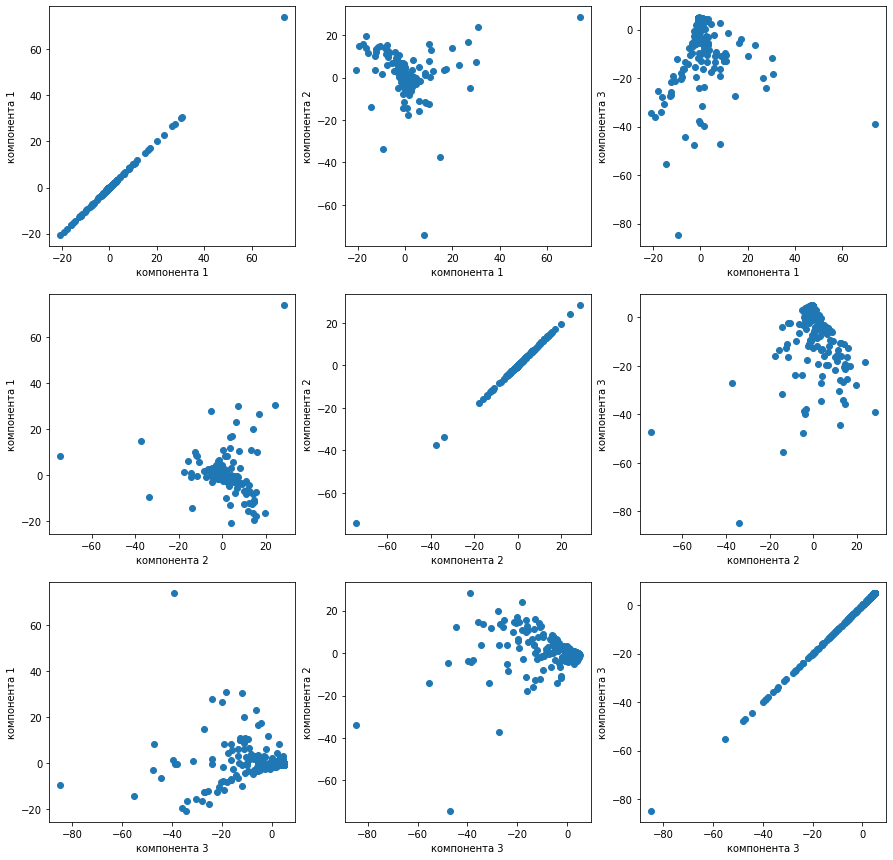

In [21]:
print('С помощью SVD')

plt.figure(figsize=(15, 15))

counter = 0
for i in range(3):
    for j in range(3):
        plt.subplot(331 + counter)
        plt.scatter(closed_features[:, i], closed_features[:, j])
        plt.xlabel('компонента ' + str(i + 1))
        plt.ylabel('компонента ' + str(j + 1))
        counter += 1
        
plt.show()

С помощью случайных гауссовских проекций


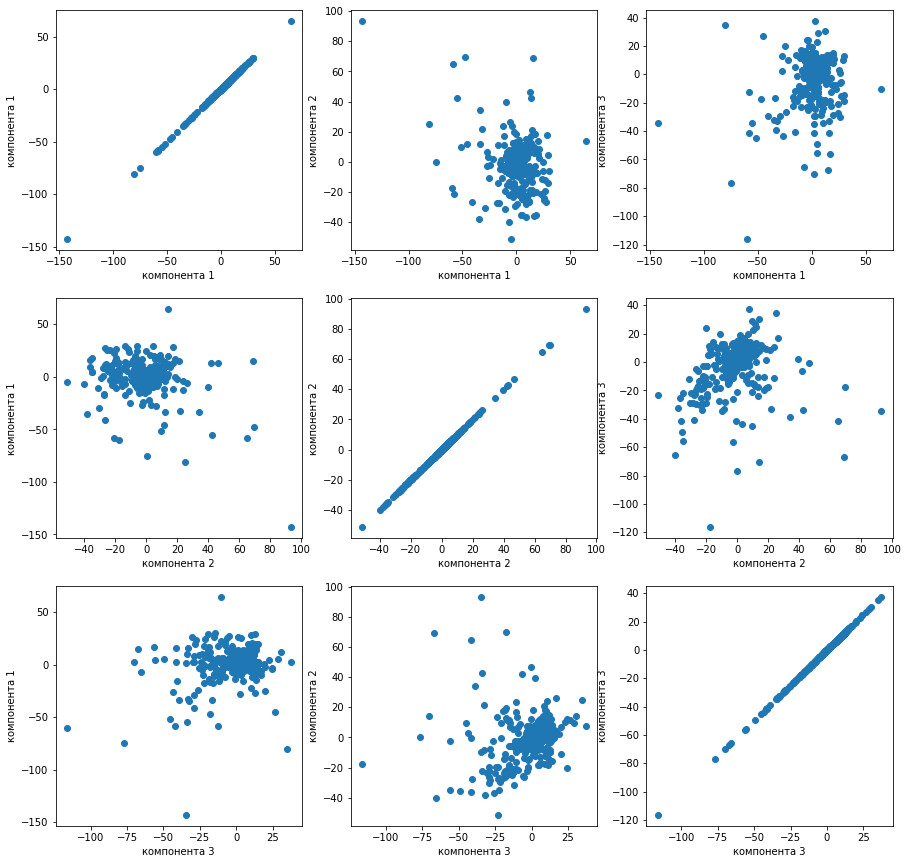

In [22]:
print('С помощью случайных гауссовских проекций')

plt.figure(figsize=(15, 15))

counter = 0
for i in range(3):
    for j in range(3):
        plt.subplot(331 + counter)
        plt.scatter(X_new[:, i], X_new[:, j])
        plt.xlabel('компонента ' + str(i + 1))
        plt.ylabel('компонента ' + str(j + 1))
        counter += 1

plt.show()

**Вывод:** На визуализациях видно, что в данных имеются выбросы, которые следует удалить. Кроме того объекты группируются рядом друг с другом и образуют один кластер, но в случае второй визуализации они более вытянуты относительно первой компоненты.

## 4. Линейная Алгебра и Машинное Обучение   (до 6 баллов)

Хорошее знание линейной алгебры очень важно в современном машинном обучении. В этом задании Вам предлагается реализовать метод машинного обучения применив знания матричного дифференцирования и итерационных методов решения систем уравнений :) 

В области машинного обучения одним из самых популярных методов бинарной классификации (предсказываем один из двух классов, $+1$ или $-1$ для каждого объекта) является логистическая регрессия. Она выводится из метода максимального правдоподобия, который приводит к следующей задаче оптимизации:

$$ L(w, X, y) = \sum_{i = 0}^{N} log (1 + exp(-y_ix_i^Tw)) + \frac{C}{2} ||w||^2 \longrightarrow \min_w$$
$$X \in R^{N \times M}, x \in R^{M}, w \in R^{M}, y \in \{-1, 1\}^N$$

Здесь $X$ - матрица объекты-признаки для обучающей выборки (по строкам объекты, по столбцам признаки), а $y$ - вектор ответов. Коэффициент $C$, вообще говоря, нужно подбирать отдельно, поскольку разные его значения приводят к разным решениям задачи оптимизации. Но так как это уже никакого отношения не имеет к линейной алгебре, то в этой задаче мы положим $\mathbf{C = 1}$

Когда мы решили задачу оптимизации (нашли $w$), мы принимаем решение о том, к какому классу относится объект по правилу $y(x) = sign(x^Tw)$. В данной части вам необходимо применить методы линейной алгебры для решения этой задачи. 

План у нас такой:
- Вычислить градиент функции $L$, эффективно запрограммировать и проверить себя
- Вычислить гессиан функции $L$,  эффективно запрограммировать и проверить себя
- Воспользоваться методом второго порядка для оптимизации 
- Внутри метода оптимизации вместо обращения матрицы, решать систему уравнений с помощью итерационного метода
- Исследовать эффективность различных методов решения системы уравнений на реальных данных

Для тестирования правильности вычисления сгенерируем аргументы небольшого размера

In [23]:
w, X, y = np.random.random(10), np.random.random((11, 10)), 2*(np.random.randint(0, 2, 11)-0.5)

**Задача 4.0 (0,5 балла)**

Запрограммируйте вычисление функции L, используйте только матричные операции (внутри не должно быть циклов).

**Замечание**: Нигде в промежуточных вычислениях не стоит вычислять значение $exp(−y_ix^Tw)$, иначе может произойти переполнение. Вместо этого следует напрямую вычислять необходимые величины с помощью специализированных для этого функций: `np.logaddexp` для `ln(1 + exp(·))` и `sp.special.expit` для `1/(1 + exp(-(·)))`.

In [24]:
def logistic(w, X, y):
    '''
        logistic(w, X, y) вычисляет функцию качества лог регрессии L(w, X, y)
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (N,)
        
        funcw: np.float 
    '''
    return np.logaddexp(0, -y*(X.dot(w))).sum() + 0.5 * w.dot(w.T)

In [25]:
logistic(w, X, y)

16.36817666791054

**Задача 4.1 (1 балл)**

Найдите градиент функции $\nabla_w L(w, X, y)$, запишите в терминах матричных операций

---
$\nabla_w L(w, X, y) = \sum\limits_{i=1}^{N} \frac{exp(-y_i x_{i}^{T}w)}{1+exp(-y_i x_{i}^{T}w)}(-y_i x_{i}^{T}) + Cw^T = \sum\limits_{i=1}^{N} \frac{1}{1+exp(y_i x_{i}^{T}w)}(-y_i x_{i}^{T}) + Cw^T$

Эффективно запрограммируйте вычисление градиента (опять же, только матричные операции!)

Обратите внимание на то, что для разреженных матриц понадобится написать немного другой код.

In [26]:
from scipy.special import expit

In [27]:
def logistic_grad(w, X, y):
    '''
        logistic_grad(w, X, y) вычисляет градиент функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        gradw: np.array размера (M,)
    '''
    if sps.issparse(X):
        gradw = (X.transpose()).dot(-y * expit(-y * X.dot(w))) + w
    else:
        gradw = (X.T).dot(-y * expit(-y*(X.dot(w)))) + w
    return gradw

In [28]:
assert(logistic_grad(w, X, y).shape == w.shape)

Очень часто при подсчёте градиента допускаются ошибки, проверьте правильность реализации подсчёта градиента с помощью конечных разностей. 

$$[\nabla f(x)]_i \approx \frac{f(x + \epsilon \cdot e_i) - f(x)}{\epsilon}~~~~$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\epsilon \approx 10^{-8}$

Ваша функция должна корректно работать хотя бы с обыкновенными (не разреженными матрицами)

In [29]:
def max_error(a, b): 
    return np.max(np.abs(a-b))

def grad_finite_diff(func, w, eps=1e-8):
    '''
        w: np.array размера (M,)
        func: скалярная функция от векторного аргумента w, func(w) =  число
        eps: np.float константа для проверки градиента
        
        dnum: np.array размера (M,), численно посчитанный градиент
    '''
    w, fval, dnum = w.astype(np.float64), func(w), np.zeros_like(w)

    for i in range(w.size):
        ei = np.zeros_like(w) # Вектор нулей (0, ..., 0, 1, 0, ..., 0) c 1 в позиции i
        ei[i] = 1
        dnum[i] = (func(w + eps * ei) - fval) / eps # Вычислите численный градиент d func/dw_i с помощью конечных разностей

    return dnum

In [30]:
mat_grad = logistic_grad(w, X, y)
num_grad = grad_finite_diff(lambda w: logistic(w, X, y), w)

err = max_error(mat_grad, num_grad)
print('err = ', err, 'ok' if err < 1e-6 else 'ошибка очень большая =(')

err =  2.5304521855673556e-07 ok


**Задача 4.2 (1 балл)**

Для некоторых задач оптимизации очень удобно использовать гессиан. 

Вычислите гессиан для функции L, запишите ответ в терминах матричных операций. 

**Упражнение**: Можно ли что-то сказать про знакоопределенность этой матрицы?

---
**Решение:** $\nabla_w^2 L(w, X, y) = -\sum\limits_{i=1}^{N} \frac{exp(y_i x_{i}^{T}w)}{(1+exp(y_i x_{i}^{T}w))^2}y_i x_{i}(-y_i x_{i}^{T}) + CE = \sum\limits_{i=1}^{N} \frac{x_{i}x_{i}^{T}}{(1+exp(y_i x_{i}^{T}w))(1+exp(-y_i x_{i}^{T}w))} + CE$.

Теперь разберёмся со знакоопределенностью гессиана. $\forall$ вектора $z: z^{T} \sum\limits_{i=1}^{N} \frac{x_{i}x_{i}^{T}}{(1+exp(y_i x_{i}^{T}w))(1+exp(-y_i x_{i}^{T}w))}z + Cz^Tz = \sum\limits_{i=1}^{N} \frac{(x_{i}^{T}z)^{T}x_{i}^{T}z}{(1+exp(y_i x_{i}^{T}w))(1+exp(-y_i x_{i}^{T}w))} + Cz^Tz \ge 0$, тк $(x_{i}^{T}z)^{T}x_{i}^{T}z \ge 0$, $z^Tz \ge 0$ и $C \ge 0$. Получаем, что гессиан - положительно определенная матрица

Эффективно запрограммируйте вычисление гессиана. Не забудьте написать отдельную рутину для разреженных матриц.

In [31]:
def logistic_hess(w, X, y):
    '''
        logistic_hess(w, X, y) вычисляет гессиан функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        hessw: np.array размера (M, M)
    '''
    if sps.issparse(X):
        diag = sps.diags(expit(-y*(X.dot(w))) * expit(y*(X.dot(w))))
        hessw = X.transpose().dot(diag).dot(X) + sps.eye(w.shape[0])
    else:
        diag = np.diag(expit(-y*(X.dot(w))) * expit(y*(X.dot(w))))
        hessw = X.T.dot(diag).dot(X) + np.eye(w.shape[0])
    return hessw

In [32]:
assert(logistic_hess(w, X, y).shape == (w.shape[0], w.shape[0]))

Теперь проверим правильность реализации подсчёта гессиана

Для гессиана проверка выглядит похожим образом

$$[\nabla^2 f(x)]_{ij} \approx \frac{f(x + \epsilon \cdot e_i + \epsilon \cdot e_j) -f(x + \epsilon \cdot e_i) - f(x + \epsilon \cdot e_j)+ f(x)}{\epsilon^2}~~~~~~~~~~~~~~~~~~~~~$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\epsilon \approx 10^{-5}$

In [33]:
def hess_finite_diff(func, w, eps=1e-5):
    '''
        w: np.array размера (M,)
        func: скалярная функция от векторного аргумента w, func(w) =  число
        eps: np.float константа для проверки градиента
        
        dnum: np.array размера (M,), численно посчитанный градиент
    '''
    w, fval, dnum = w.astype(np.float64), func(w).astype(np.float64), np.zeros((w.size, w.size), dtype=np.float64)
    n, m = dnum.shape
    for i in range(n):
        ei = np.zeros_like(w)
        ei[i] = 1
        for j in range(m):
            ej = np.zeros_like(w)
            ej[j] = 1
            dnum[i][j] = (func(w + eps*ei + eps*ej) - func(w + eps*ei) - func(w + eps*ej) + func(w)) / (eps * eps)
    return dnum

In [34]:
mat_grad = logistic_hess(w, X, y)
num_grad = hess_finite_diff(lambda w: logistic(w, X, y), w)

err = max_error(mat_grad, num_grad)

print('err = ', err)
print('ok' if max_error(mat_grad, num_grad) < 1e-4 else 'ошибка оч большая =(') 

err =  7.858709530850216e-05
ok


**Задача 4.3 (3+ баллов)**

Так как наша задача оптимизации оказывается выпуклой (см. упражнение про знакоопределённость Гессиана), её можно эффективно решать методом второго порядка, например, методом Ньютона. Напомним, что в общем виде метод Ньютона для решения уравнения (системы уравнений) $H(z) = 0$ имеет вид

$$z_{k+1} = w_k - \mathbf{\alpha_k}\left(\nabla H(z_k)\right)^{-1}H(z_k)$$

Множитель $a_k$ не вполне каноничен, но его введение может ускорять сходимость.

Решение задачи оптимизации $f(w) \rightarrow \min\limits_w$ сводится к нахождению нулей градиента $\nabla f(w) = 0$. Получаем следующий итеративный процесс:

$$w_{k + 1} = w_k - \alpha_k\left(\nabla^2 f(x_k)\right)^{-1} \cdot \nabla f(x_k) =: w_k - \alpha_k d_k$$

Иными словами, основная идея метода Ньютона -- на шаге $k$ выбрать направление спуска $d_k$ с помощью градиента и гессиана, определить длину шага $\alpha_k$ по направлению $d_k$, и повторять сей процесс до сходимости (в выпуклой задаче можно считать, что это 20 итераций).

В методе Ньютона каждое следующее направление оптимизации выбирается как 

$$d_{k+1} = -(\nabla^2 f(x_k))^{-1} \cdot \nabla f(x_k)$$

но, вот беда, операция поиска обратной матрицы очень дорогая и не устойчивая, поэтому будем искать $d_{k+1}$ как решение системы уравнений

$$\nabla^2 f(x_k) d_{k+1} = -\nabla f(x_k)$$

Первым делом вам нужно будет реализовать метод Ньютона.

*Замечание*: Если вы хорошо реализовали вычисление градиента и гессиана, то в функции `newton` вам не понадобилось отдельно обрабатывать разреженные матрицы.

In [35]:
from scipy.optimize.linesearch import line_search_armijo

def newton(func, grad, hess, x0, solver, max_iter=20):
    '''
        func: скалярная функция от вектора размера shape(w0)
        grad: функция вычисляющая градиент функции func
        hess: функция вычисляющая гессиан  функции func
        
        w0: вектор, первая точка в процессе оптимизации 
        solver: функция от двух аргументов A, b находит решение системы Ax=b
        max_iter: количество итераций метода
    '''
    
    x, fvals, ngrads = x0.copy().astype(np.float), [], []

    for iter in range(max_iter):
        fvalx, gradx, hessx = func(x), grad(x), hess(x)
        d = solver(hessx, gradx) # Решите систему hess * x = grad 
        alpha = line_search_armijo(func, x, -d, gradx, fvalx)[0] # Поиск шага по направлению d, с помощью быстрой одномерной оптимизации, используйте line_search_armijo
        x = x - alpha * d # Шаг метода по направлению d с коэффициентом alpha
        fvals.append(fvalx)
        ngrads.append(np.linalg.norm(gradx))

    return x, fvals, ngrads

In [36]:
# Пример запуска

func = lambda w: logistic(w, X, y)
grad = lambda w: logistic_grad(w, X, y)
hess = lambda w: logistic_hess(w, X, y)
gauss_  = lambda A, b: spla.spsolve(A, b) if sps.issparse(A) else sla.solve(A, b)
lgmres_  = lambda A, b: spla.lgmres(A, b, tol=1e-2)[0]
cg_  = lambda A, b: spla.cg(A, b, tol=1e-2)[0]

%time w_opt, fvals, ngrads = newton(func, grad, hess, w, cg_) 

CPU times: user 8.22 ms, sys: 1.08 ms, total: 9.29 ms
Wall time: 17.7 ms


В этом задании вам необходимо в зависимости от метода решения системы уравнений (гаусс, CG, GMRES) исследовать:
- зависимость времени работы метода оптимизации от выбора метода решения системы;
- скорость сходимости метода оптимизации в зависимости от точности решения системы уравнений (параметр `tol`);
- какую часть времени метод тратит на решение системы уравнений и какую на вычисление гессиана и градиента.

Эксперименты нужно провести на нескольких наборах данных. Рассмотрите следующие три ситуации: 
- малое число признаков d < 100
- среднее число признаков d ~ 500 
- большое число признаков d ~ 1000

Мы будем поощрять любые дополнительные исследования, например, если вы попытаетесь проверить статистическую значимость результатов экспериментов: ведь если какой-нибудь метод показал себя лучше в одном-единственном эксперименте, то это ещё ничего не значит.

**Рекомендация**: можете рассмотреть три набора данных, которые можно скачать с сайта [LIBSVM1](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html): **a9a**, **w8a** (много объектов, сравнительно немного признаков) и **colon-cancer** (в нём достаточно мало объектов, но зато гораздо больше признаков).

Любой набор данных с сайта LIBSVM представляет из себя текстовый файл в формате svmlight. Чтобы считать такой текстовый файл, можно использовать функцию [load_svmlight_file](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html) из модуля sklearn.datasets. Эта функция всегда возвращает матрицу X типа sp.sparse.csr_matrix (разреженная марица). В датасете **colon-cancer** матрица X не будет разреженной, поэтому сразу же после вызова функции load_svmlight_file следует привести X к типу np.ndarray. Это можно сделать с помощью команды X = X.toarray().

In [37]:
from sklearn.datasets import load_svmlight_file

X1, y1 = load_svmlight_file('a9a.txt')
X2, y2 = load_svmlight_file('w8a.txt')

X3, y3 = load_svmlight_file('colon-cancer')
X3 = X3.toarray()

In [38]:
datasets = [(X1, y1), (X2, y2), (X3, y3)]

In [39]:
gauss_  = lambda A, b: spla.spsolve(A, b) if sps.issparse(A) else sla.solve(A, b)
lgmres_  = lambda A, b: spla.lgmres(A, b, tol=1e-2)[0]
cg_  = lambda A, b: spla.cg(A, b, tol=1e-2)[0]

In [40]:
from collections import defaultdict
from datetime import datetime

time = defaultdict(list)

for X, y in datasets:
    w = np.random.random(X.shape[1])
    func = lambda w: logistic(w, X, y)
    grad = lambda w: logistic_grad(w, X, y)
    hess = lambda w: logistic_hess(w, X, y)
    
    print('Количество объектов: {}, количество признаков: {}'.format(*X.shape))
    
    print('gauss')
    begin = datetime.now()
    %time w_opt, fvals, ngrads = newton(func, grad, hess, w, gauss_, 100) 
    print("Норма градиента ", np.max(ngrads[-1]))
    end = datetime.now()
    time['gauss'].append((end - begin).total_seconds())
    
    print('lgmres')
    begin = datetime.now()
    %time w_opt, fvals, ngrads = newton(func, grad, hess, w, lgmres_, 100) 
    print("Норма градиента ", np.max(ngrads[-1]))
    end = datetime.now()
    time['lgmres'].append((end - begin).total_seconds())
    
    print('cg')
    begin = datetime.now()
    %time w_opt, fvals, ngrads = newton(func, grad, hess, w, cg_, 100)
    print("Норма градиента ", np.max(ngrads[-1]))
    end = datetime.now()
    time['cg'].append((end - begin).total_seconds())
    
    print('--------------------------------------------------------')

Количество объектов: 32561, количество признаков: 123
gauss
CPU times: user 5.63 s, sys: 215 ms, total: 5.84 s
Wall time: 7.25 s
Норма градиента  1.9657611519649793e-11
lgmres


/Users/ekaterinakuzina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  


CPU times: user 5.15 s, sys: 142 ms, total: 5.29 s
Wall time: 5.71 s
Норма градиента  0.006278335036679835
cg
CPU times: user 5.09 s, sys: 139 ms, total: 5.23 s
Wall time: 5.6 s
Норма градиента  0.00790681087905734
--------------------------------------------------------
Количество объектов: 49749, количество признаков: 300
gauss
CPU times: user 19 s, sys: 582 ms, total: 19.6 s
Wall time: 12 s
Норма градиента  3.646678173860654e-08
lgmres
CPU times: user 17.6 s, sys: 442 ms, total: 18 s
Wall time: 13.1 s
Норма градиента  0.009471995139214283
cg
CPU times: user 17.5 s, sys: 418 ms, total: 18 s
Wall time: 11.6 s
Норма градиента  0.00024804127082709627
--------------------------------------------------------
Количество объектов: 62, количество признаков: 2000
gauss
CPU times: user 39.5 s, sys: 1.58 s, total: 41 s
Wall time: 23.8 s
Норма градиента  5.6420864319851125e-15
lgmres
CPU times: user 7.37 s, sys: 620 ms, total: 7.99 s
Wall time: 4.77 s
Норма градиента  0.00849926013434786
cg
CPU 

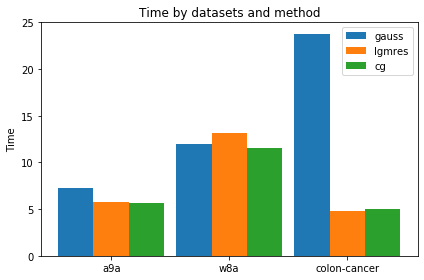

In [41]:
ind = np.arange(3)  # the x locations for the groups
width = 0.6  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width / 2, time['gauss'], width / 2,
                label='gauss')
rects2 = ax.bar(ind, time['lgmres'], width / 2,
                label='lgmres')
rects3 = ax.bar(ind + width / 2, time['cg'], width / 2,
                label='cg')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time')
ax.set_title('Time by datasets and method')
ax.set_xticks(ind)
ax.set_xticklabels(('a9a', 'w8a', 'colon-cancer'))
ax.legend()

fig.tight_layout()

plt.show()

Мы исследуем время работы метода Ньютона с применением различных методов для решения системы уравнений, зависящей от числа признаков. Сразу видно, что на датасете colon-cancer(2000 признаков) метод Ньютона с применением метода Гаусса имеет наихудшее время работы. Заметим, что на датасетах меньшего размера метод Гаусса хоть и не даёт выигрыш по времени, но его значение близко к минимальному. На датасете с числом признаков около 100 и 300 хорошо показал себя метод cg, тогда как на датасете с 2000 признаков лучше всего работает метод lgmres.

In [42]:
tols = [1, 1e-1, 1e-2, 1e-3, 1e-4]

lgmres_time = []
cg_time = []

for X, y in datasets:
    w = np.random.random(X.shape[1])
    func = lambda w: logistic(w, X, y)
    grad = lambda w: logistic_grad(w, X, y)
    hess = lambda w: logistic_hess(w, X, y)
    
    lgmres_tols_time = []
    cg_tols_time = []
    
    for tol in tols:
        lgmres_  = lambda A, b: spla.lgmres(A, b, tol=tol)[0]
        begin = datetime.now()
        w_opt, fvals, ngrads = newton(func, grad, hess, w, lgmres_, 100) 
        end = datetime.now()
        lgmres_tols_time.append((end - begin).total_seconds())


        cg_  = lambda A, b: spla.cg(A, b, tol=tol)[0]
        begin = datetime.now()
        w_opt, fvals, ngrads = newton(func, grad, hess, w, cg_, 100) 
        end = datetime.now()
        cg_tols_time.append((end - begin).total_seconds())
    
    lgmres_time.append(lgmres_tols_time)
    cg_time.append(cg_tols_time)

/Users/ekaterinakuzina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  app.launch_new_instance()


In [43]:
dataset = {0: 'a9a', 1: 'w8a', 2: 'colon-cancer'}

Исследуем скорость сходимости метода оптимизации в зависимости от точности решения системы уравнений


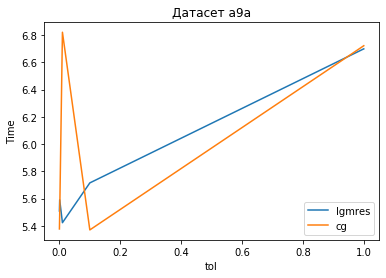

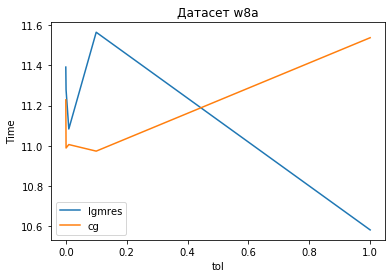

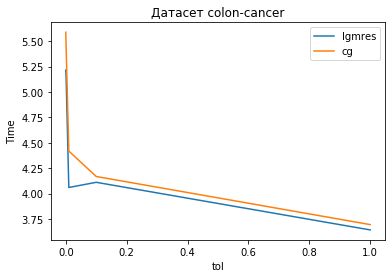

In [44]:
print('Исследуем скорость сходимости метода оптимизации в зависимости от точности решения системы уравнений')

for i in range(3):
    plt.title('Датасет ' + dataset[i])
    plt.xlabel('tol')
    plt.ylabel('Time')
    
    plt.plot(tols, lgmres_time[i])
    plt.plot(tols, cg_time[i])
    plt.legend(['lgmres', 'cg'])
    plt.show()

Понятно, что параметры метода зависят от конкретной задачи. Однако можно сказать, что tol = 0.01 является оптимальным для решения трёх наших задач. 

In [45]:
def newton_times(func, grad, hess, x0, solver, max_iter=20):
    '''
        func: скалярная функция от вектора размера shape(w0)
        grad: функция вычисляющая градиент функции func
        hess: функция вычисляющая гессиан  функции func
        
        w0: вектор, первая точка в процессе оптимизации 
        solver: функция от двух аргументов A, b находит решение системы Ax=b
        max_iter: количество итераций метода
    '''
    
    x, fvals, ngrads = x0.copy().astype(np.float), [], []
    grad_time = 0
    hess_time = 0
    solver_time = 0
    
    for iter in range(max_iter):
        fvalx = func(x)
        t1 = datetime.now()
        gradx = grad(x)
        t2 = datetime.now()
        hessx = hess(x)
        t3 = datetime.now()
        d = solver(hessx, gradx) # Решите систему hess * x = grad 
        t4 = datetime.now()
        
        grad_time += (t2 - t1).total_seconds()
        hess_time += (t3 - t2).total_seconds()
        solver_time += (t4 - t3).total_seconds()
        
        alpha = line_search_armijo(func, x, -d, gradx, fvalx)[0] # Поиск шага по направлению d, с помощью быстрой одномерной оптимизации, используйте line_search_armijo
        x = x - alpha * d # Шаг метода по направлению d с коэффициентом alpha
        fvals.append(fvalx)
        ngrads.append(np.linalg.norm(gradx))

    return grad_time, hess_time, solver_time

In [46]:
for i, data in enumerate(datasets):
    X, y = data[0], data[1]
    w = np.random.random(X.shape[1])

    func = lambda w: logistic(w, X, y)
    grad = lambda w: logistic_grad(w, X, y)
    hess = lambda w: logistic_hess(w, X, y)
    
    print("Датасет: ", dataset[i])
    
    gauss_  = lambda A, b: spla.spsolve(A, b) if sps.issparse(A) else sla.solve(A, b)
    t1 = datetime.now()
    grad_time, hess_time, solver_time = newton_times(func, grad, hess, w, gauss_, 100)
    t2 = datetime.now()
    all_time = (t2 - t1).total_seconds()
    print("--gauss")
    print("----{} часть времени на вычисление градиента".format(grad_time / all_time))
    print("----{} часть времени на вычисление гессиана".format(hess_time / all_time))
    print("----{} часть времени на решение системы уравнений\n".format(solver_time / all_time))
    
    lgmres_  = lambda A, b: spla.lgmres(A, b, tol=1e-1)[0]
    t1 = datetime.now()
    grad_time, hess_time, solver_time = newton_times(func, grad, hess, w, lgmres_, 100)
    t2 = datetime.now()
    all_time = (t2 - t1).total_seconds()
    print("--lgmress")
    print("----{} часть времени на вычисление градиента".format(grad_time / all_time))
    print("----{} часть времени на вычисление гессиана".format(hess_time / all_time))
    print("----{} часть времени на решение системы уравнений\n".format(solver_time / all_time))
        
    cg_  = lambda A, b: spla.cg(A, b, tol=1e-1)[0]
    t1 = datetime.now()
    grad_time, hess_time, solver_time = newton_times(func, grad, hess, w, cg_, 100)
    t2 = datetime.now()
    all_time = (t2 - t1).total_seconds()
    print("--cg")
    print("----{} часть времени на вычисление градиента".format(grad_time / all_time))
    print("----{} часть времени на вычисление гессиана".format(hess_time / all_time))
    print("----{} часть времени на решение системы уравнений\n".format(solver_time / all_time))

Датасет:  a9a
--gauss
----0.03678022253590378 часть времени на вычисление градиента
----0.8165297202312484 часть времени на вычисление гессиана
----0.03850879133269542 часть времени на решение системы уравнений



/Users/ekaterinakuzina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.


--lgmress
----0.045319355093732354 часть времени на вычисление градиента
----0.8797367806056321 часть времени на вычисление гессиана
----0.007798750204442868 часть времени на решение системы уравнений

--cg
----0.03956436537333825 часть времени на вычисление градиента
----0.8713982114896499 часть времени на вычисление гессиана
----0.007577686403365457 часть времени на решение системы уравнений

Датасет:  w8a
--gauss
----0.034205853685065665 часть времени на вычисление градиента
----0.8033762429011759 часть времени на вычисление гессиана
----0.08006654428200786 часть времени на решение системы уравнений

--lgmress
----0.037819543159356844 часть времени на вычисление градиента
----0.853968667185422 часть времени на вычисление гессиана
----0.023510821178965535 часть времени на решение системы уравнений

--cg
----0.036729017674574885 часть времени на вычисление градиента
----0.8519077787251458 часть времени на вычисление гессиана
----0.024059978948020574 часть времени на решение системы ур

На датасетах с большим числом объектов и не очень большим количеством признаков большую часть времени занимает вычисление гессиана, тогда как вычисление решения системы уравнения занимает меньшую часть. Логически это вполне понятно, т.к. при вычислении гессиана и градиента нужно найти некоторую линенйую комбинацию между объектами, а объектов очень много. Число признаков же в разы меньше, поэтому и найти решение системы мы на скорее всего найдем за меньшее время (если не говорить о том, правильно ли сойдётся метод при заданных параметрах).  
На датасете с меньшим число объектов и большим числом признаков всё не так однозначно. Время нахождения решения системы уравнений методом Гаусса больше, чем вычисление гессиана и градиента. Для lgmres и cg наоборот.

**Задача 4.4 (0 балов, весь код написан за вас, но очень красивые картинки)** 

Давайте визуализируем наш метод, а то хочется глазами посмотреть. Просто запустите код:

In [47]:
from scipy import optimize

def expand(X):
    X_ = np.zeros((X.shape[0], 6))
    X_[:,0:2] = X
    X_[:,2:4] = X**2
    X_[:,4] = X[:,0] * X[:,1]
    X_[:,5] = 1;
    return X_

def visualize(X, y, w, loss, n_iter, h=0.01):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    plt.clf()
    Z = classify(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap='rainbow', alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
def viz_opt(func, gradf, hessf, X, y, n_iter=10):
    a = None
    loss1 = np.zeros(n_iter)
    plt.figure(figsize=(12,5))
    ind = np.arange(X.shape[0])
    
    w, d = np.zeros(X.shape[1]), np.zeros(X.shape[1])
    
    for i in range(n_iter):        
        loss1[i] += func(w)
        visualize(X, y, w, loss1, n_iter)
        
        fvalx, gradx, hessx = func(w), grad(w), hess(w)
        d = spla.cg(hessx, -gradx)[0]
        alpha = line_search_armijo(func, w, d, gradx, fvalx)[0]
        w += alpha*d
        
    visualize(X, y, w, loss1, n_iter)
    
    q = plt.clf()
    plt.show()

In [48]:
from sklearn.datasets import make_moons, make_circles, make_classification

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2)
X += np.random.random(X.shape)

datasets = [make_moons(noise=0.1), make_circles(noise=0.1, factor=0.5), (X, y)]

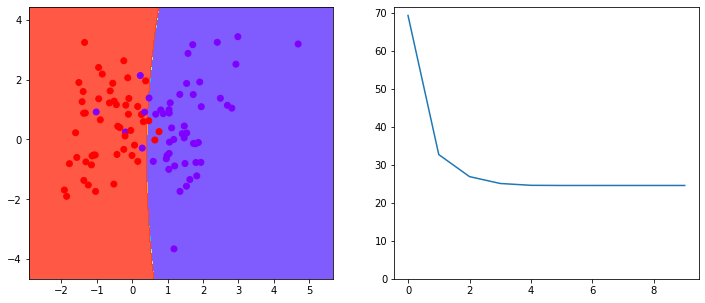

<Figure size 864x360 with 0 Axes>

In [49]:
from IPython import display

def classify(X, w):
    return np.sign(1.0 / (1.0 + np.exp(-X.dot(w))) - 0.5)

func = lambda w: logistic(w, X, y)
grad = lambda w: logistic_grad(w, X, y)
hess = lambda w: logistic_hess(w, X, y)

for X, y in datasets:
    X, y = expand(X), -2*(y-0.5)
    a = viz_opt(func, grad, hess, X, y) 